In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
# import reverse_geocoder as rg
import time
import datetime
from chinese_calendar import is_workday,is_holiday,get_holiday_detail

from sklearn import model_selection
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LogisticRegression 
from sklearn.svm import SVR
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import ExtraTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import BaggingRegressor

from sklearn.preprocessing import StandardScaler # standardlization
from sklearn import preprocessing  # normalization
from sklearn import metrics
from sklearn import linear_model

## Data Preprocessing

In [2]:
# load dataset
df = pd.read_csv('grid_prediction.txt',sep = '|')
# drop the missing value
df = df[df['datatim'] != '\\N']
# df = df.dropna(axis=0,how='any')
# transfer the string format into date time format
df['datatim'] = pd.to_datetime(df['datatim'])

### Derive some categorical attributes from data time

In [3]:
# input: dataframe
# example: add_element(df)
def add_element(dataset):
    weekend = []
    holiday = []
    time_ = []
    for i in dataset['datatim']:
        # time in "00:00:00" to "06:00:00" : early morning
        if datetime.time(0, 0, 0) < i.time() < datetime.time(6, 0, 0):
            time_.append('early morning')
        # time in "6:00:00" to "12:00:00" : morning
        elif datetime.time(6, 0, 0) < i.time() < datetime.time(12, 0, 0):
            time_.append('morning')
        # time in "12:00:00" to "18:00:00" : afternoon
        elif datetime.time(12, 0, 0) < i.time() < datetime.time(18, 0, 0):
            time_.append('afternoon')
        # time in "18:00:00" to "24:00:00" : evening
        else:
            time_.append('evening')
            
        date = time.strptime(str(i),'%Y-%m-%d %H:%M:%S')

        # check whether is weekend or not
        if date.tm_wday < 5:
            weekend.append(False)
        else:
            weekend.append(True)

        # check whether is holiday or not
        if is_holiday(i) and get_holiday_detail(i)[1] != None:
            holiday.append(True)
        else:
            holiday.append(False)
            
    dataset.insert(1,'weekend',weekend)
    dataset.insert(2,'holiday',holiday)
    dataset.insert(3,'time',time_)
    
    hour = [int(i.split(" ")[1].split(":")[0]) for i in dataset.datatim.astype('str')]
    minu = [int(i.split(" ")[1].split(":")[1]) for i in dataset.datatim.astype('str')]
    
    dataset.insert(1,'hour',hour)
    dataset.insert(2,'minute',minu)
    dataset.insert(3, 'hourfloat',dataset.hour+dataset.minute/60)
    dataset.insert(4, 'x', np.sin(2.*np.pi*dataset.hourfloat/24.))
    dataset.insert(5, 'y', np.cos(2.*np.pi*dataset.hourfloat/24.))

    #add day of week categorical attributes
    idlist = [0,1,2,3,4,5,6]
    day = ['Sun','Mon','Tue','Wed','Thur','Fri','Sat']
    match = pd.DataFrame({'id':idlist, 'day':day})

    dataset.datatim = pd.to_datetime(dataset.datatim)
    day_of_week = [match.loc[i.weekday(),'day'] for i in dataset.datatim]
    dataset.insert(1,'day_of_week',day_of_week)

    #check cyclic attribute
    #data_new.sample(50).plot.scatter('x','y').set_aspect('equal') 
    return dataset

### Calculate crowd flow (cnt) after 15 mins

In [4]:
def get_cnt_after_15min(grid_df):
    next15_cnt = []
    for i in range(len(grid_df)):
        next_time = grid_df.iloc[i]['datatim'] + datetime.timedelta(minutes = 15)
        cnt_df = grid_df[grid_df['datatim'] == next_time]['cnt']
        if cnt_df.empty:
            cnt = np.nan
        else:
            cnt = cnt_df.iloc[0]
            cnt = int(cnt)
        next15_cnt.append(cnt)
        
    grid_df['next15_cnt'] = next15_cnt
    grid_df = grid_df.dropna(axis=0,how='any')
    grid_df['next15_cnt'] = grid_df['next15_cnt'].astype('int')
    return grid_df

### Feature Selection

In [5]:
# eliminate: list format of useless attributes
def feature_selection(X, eliminate):
    list1 = X.columns.tolist()
    list2 = eliminate
    select = [i for i in list1 if i not in list2]
    X_adj = X[select]
    return X_adj

### Data Preprocessing  (standardization or normalization)

In [6]:
# no change or normalization or standardization
def norm_or_stand(X, y, choice=None):
    # convert the catrgorical variables into dummy variables
    X_dum = pd.get_dummies(X)
    # do standardization or normalization
    if choice:
        if choice == "norm":
            scale_x = preprocessing.MinMaxScaler()
            scale_y = preprocessing.MinMaxScaler() 
        if choice == 'stand':
            scale_x = StandardScaler()
            scale_y = StandardScaler()

        X_dum = scale_x.fit_transform(X_dum)
        y = np.array(y).reshape(-1,1)
        y = scale_y.fit_transform(y)
        y = y.ravel()
        return X_dum, y, scale_y
    else:
        return X_dum, y

### Model Training

In [11]:
# model training
def all_model_train(X_dum, y, models, models_str, scale_y = None):
    X_train,X_test,y_train,y_test = model_selection.train_test_split(X_dum,y,test_size = 0.25,random_state = 1)
    score_=[] # A list to store all the score value of the model
    mse_ = [] # A list to store all the MSE value of the model
    mae_ = [] # A list to store all the MAE value of the model
    r2_ = [] # A list to store all the R square value of the model
    # A list to store the predicted y, if scale_y == None, scale_pred_y is the true prediction y, otherwise, 
    # the scale_pred_y is the prediction y after transformation
    scale_pred_y = [] 
    # the true prediction y 
    prediction = []
    
    for name,model in zip(models_str,models):
        model = model   #model building
        model.fit(X_train,y_train)
        y_pred = model.predict(X_test)
        scale_pred_y.append(y_pred)
        
        # transform the scale y into the true prediction y
        if scale_y:
            y_pred_back = scale_y.inverse_transform(y_pred.reshape(-1, 1))
            #print(y_pred_back)
            prediction.append(y_pred_back)
        else:
            prediction = scale_pred_y
            
        score = model.score(X_test,y_test)
        score_.append(str(score)[:5])
        
        # calculate the mean squared error of the model
        mse = metrics.mean_squared_error(y_pred,y_test)
        mse_.append(str(mse))
        # calculate the mean absolute error of the model
        mae = metrics.mean_absolute_error(y_pred,y_test)
        mae_.append(str(mae))
        # calculate R^2 of the model
        r2 = metrics.r2_score(y_pred,y_test)
        r2_.append(str(r2))
        
    df = pd.DataFrame({'Model':models_str,'Score':score_,'MSE':mse_,'MSA':mae_,'R-sqaured':r2_})
    return df, prediction, y_test, X_test, scale_pred_y

### Whole Process

In [12]:
# eliminate: A list of attributes that need to be eliminate
def crowdflow(df, grid_id, eliminate, choice=None):
    # Select a specific grid id
    df = df[df['grid_id'] == grid_id]
    # Derive some categorical attributes from data time
    df = add_element(df)
    # Calculate crowd flow (cnt) after 15 mins
    df = get_cnt_after_15min(df)
    # X, y
    X = df[['day_of_week','x','y','weekend','holiday','time','cnt']]
    y = df["next15_cnt"]
    
    # select the useful attributes 
    X = feature_selection(X, eliminate)
    print('Using attributes:',X.columns.tolist())
    print('data:', choice)
    if choice:
        X_dum, y, scale_y = norm_or_stand(X, y, choice)
        outcome, pred, y_test, X_test, nor_pred_y = all_model_train(X_dum, y, models, models_str,scale_y)
    else:
        X_dum, y = norm_or_stand(X, y, choice)
        outcome, pred, y_test, X_test, nor_pred_y = all_model_train(X_dum, y, models, models_str)
    return outcome, pred, y_test, nor_pred_y

In [13]:
# attribute eliminate list
selection = [[''],['day_of_week'],['weekend'],['holiday'],['time'],
             ['day_of_week'],['x', 'y'],['weekend','holiday'],
             ['day_of_week','x','y'], ['day_of_week','weekend','holiday'],['x','y','time']]

#all candidate model
models=[KNeighborsRegressor(),RandomForestRegressor(),GradientBoostingRegressor()]
models_str=['KNNRegressor','RandomForest','GradientBoost']

### Final Model

In [14]:
out_no_weekend, pred, y_test, scale_pred_y = crowdflow(df, 5004, selection[2],'norm')
out_no_weekend

/Users/wenyan/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
<ipython-input-4-66cf5162be66>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grid_df['next15_cnt'] = next15_cnt
<ipython-input-4-66cf5162be66>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.or

Using attributes: ['day_of_week', 'x', 'y', 'holiday', 'time', 'cnt']
data: norm


,Model,Score,MSE,MSA,R-sqaured
0,KNNRegressor,0.958,0.00014645363796033774,0.007096626183619449,0.9554797789576976
1,RandomForest,0.959,0.00014163853728525272,0.006817629698968682,0.9574740564998182
2,GradientBoost,0.961,0.00013458859606905286,0.007174334107881755,0.9587227859368489


### Prediction of the test dataset

In [15]:
pred

[array([[9311.4],
        [5286.2],
        [9108.8],
        ...,
        [7868.2],
        [8121.8],
        [7939. ]]),
 array([[9220.74],
        [5661.3 ],
        [9059.57],
        ...,
        [7780.83],
        [8093.12],
        [7831.69]]),
 array([[9234.95247135],
        [5707.77751584],
        [9105.63734676],
        ...,
        [7817.01114582],
        [8090.46871577],
        [7786.54919509]])]

### Draw a heat map graph to show the relationship between the numerical attributes

In [17]:
heat_map_df = df[df['grid_id'] == 5004]
heat_map_df = add_element(heat_map_df)
heat_map_df = get_cnt_after_15min(heat_map_df)
heat_map_df = heat_map_df[['day_of_week','x','y','weekend','holiday','time','cnt','next15_cnt']]

/Users/wenyan/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
<ipython-input-4-66cf5162be66>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grid_df['next15_cnt'] = next15_cnt
<ipython-input-4-66cf5162be66>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.or

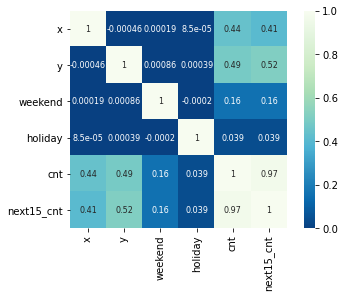

In [21]:
import seaborn as sns
# correlation
corr = heat_map_df.corr()
# heat map graph
sns.heatmap(corr, cmap='GnBu_r', square=True, annot=True,annot_kws={'size':8})
# plt.savefig('heatmap.png')

In [25]:
scale_pred_y

[array([0.72419678, 0.37372225, 0.70655638, ..., 0.59853722, 0.6206182 ,
        0.60470178]),
 array([0.716303  , 0.40638224, 0.70226992, ..., 0.59092991, 0.61812103,
        0.59535829]),
 array([0.71754049, 0.41042904, 0.70628101, ..., 0.5940802 , 0.61789018,
        0.59142788])]

In [23]:
y_test

array([0.70587723, 0.3729212 , 0.70370048, ..., 0.58624293, 0.61532434,
       0.58606879])

### Prediction Visualization

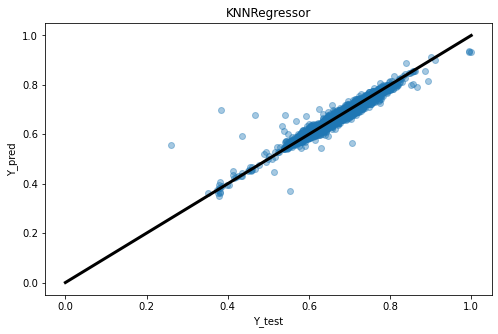

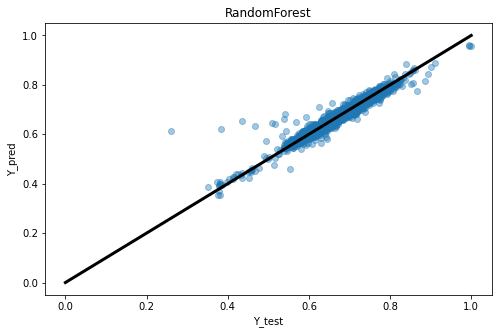

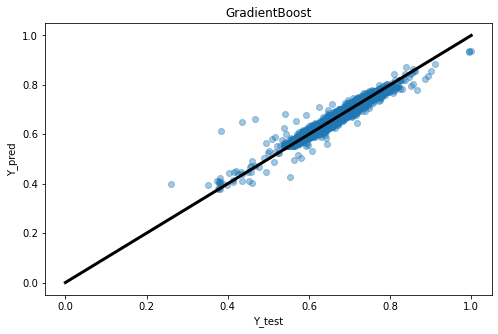

In [26]:
for i in range(len(scale_pred_y)):
    plt.figure(figsize = (8,5))
    plt.xlabel('Y_test')
    plt.ylabel('Y_pred')
    
    plt.grid(False) 
    plt.scatter(y_test, scale_pred_y[i],  alpha=0.4)
    plt.plot([0,1],[0,1],linewidth = '3',color='#000000')
    plt.title(models_str[i])
    plt.show()